# Course :  Machine learning Use-case lab
# Name : Kulboboev Shukhrat
# Project : Time series analysis

In [188]:
# Importing the libraries
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA


In [189]:
# Read the data and show the head of some 
data = pd.read_csv("Electric_Production.csv")
data.columns=["date","consumption"]

In [190]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         397 non-null    object 
 1   consumption  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [191]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
consumption,397.0,88.847218,15.387834,55.3151,77.1052,89.7795,100.5244,129.4048


In [192]:
data.shape

(397, 2)

In [193]:
data['date']=pd.to_datetime(data['date'],infer_datetime_format=True)

In [194]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         397 non-null    datetime64[ns]
 1   consumption  397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


In [195]:
# settting index
data = data.set_index('date',inplace=False)

In [196]:
data.head

<bound method NDFrame.head of             consumption
date                   
1985-01-01      72.5052
1985-02-01      70.6720
1985-03-01      62.4502
1985-04-01      57.4714
1985-05-01      55.3151
...                 ...
2017-09-01      98.6154
2017-10-01      93.6137
2017-11-01      97.3359
2017-12-01     114.7212
2018-01-01     129.4048

[397 rows x 1 columns]>

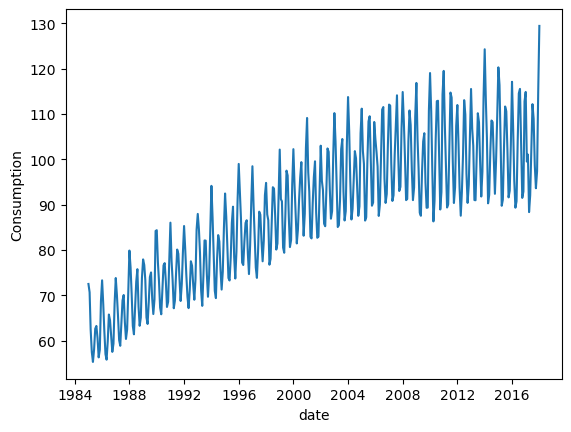

In [197]:
# plot the dataset

plt.figure()
plt.xlabel("date")
plt.ylabel("Consumption")
plt.plot(data)
plt.show()

we can see here , the consumption of electricty was increasing and folowing trends during the given time . It looks non-stationary time series

## Now , we try to check the stationary of the given data by creating functions 

In [198]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    plt.figure(figsize=(10,5))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    data_test = adfuller(timeseries['consumption'], autolag='AIC')
    dataoutput = pd.Series(data_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in data_test[4].items():
        dataoutput['Critical Value (%s)'%key] = value
    print(dataoutput)

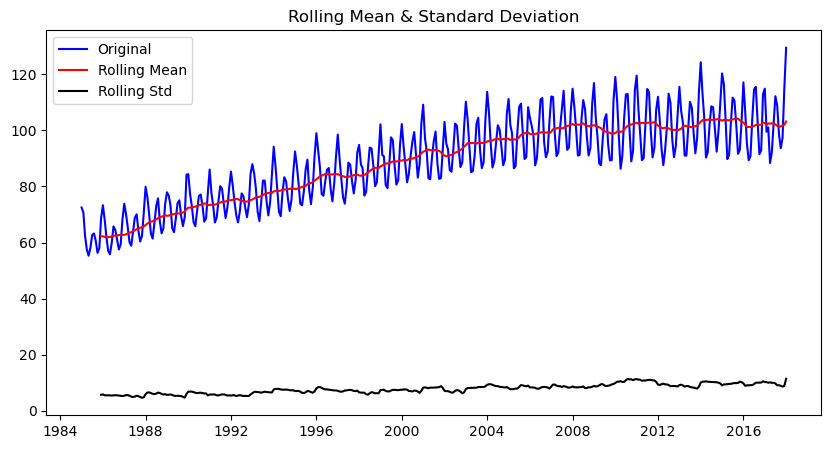

Results of Dickey Fuller Test:
Test Statistic                  -2.256990
p-value                          0.186215
#Lags Used                      15.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


In [199]:
test_stationarity(data)

as you can see in the plot, mean value also follow the trend and shows non- stationary but when it comes to standart deviation , it looks stationary during the time
in order to consider this data stationary , mean and std should be parrallel to x axis but in our case as i said , mean value is not following this as a result we can say , that data is not stationary

Now we checked the Dickey fuller and we can say , p value is above thershold and accept H0 and test statistics also is lower the critical values. This test also shows that our dataset is non-stationary

## But in order to achieve the stationary data, we should preform some transformation algorithms in here. Let's perform Log Transformation.

In [200]:
data_log =np.log(data)

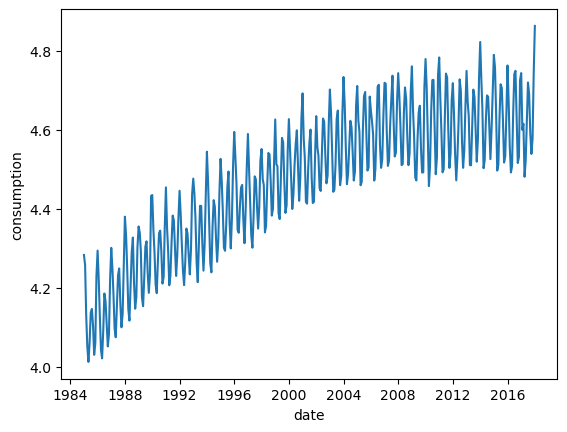

In [201]:
plt.figure()

plt.xlabel("date")
plt.ylabel("consumption")
plt.plot(data_log)
plt.show()

In [202]:
rollmean_log = data_log.rolling(window=12).mean()
rollstd_log = data_log.rolling(window=12).std()

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation (Logarithmic Scale)')

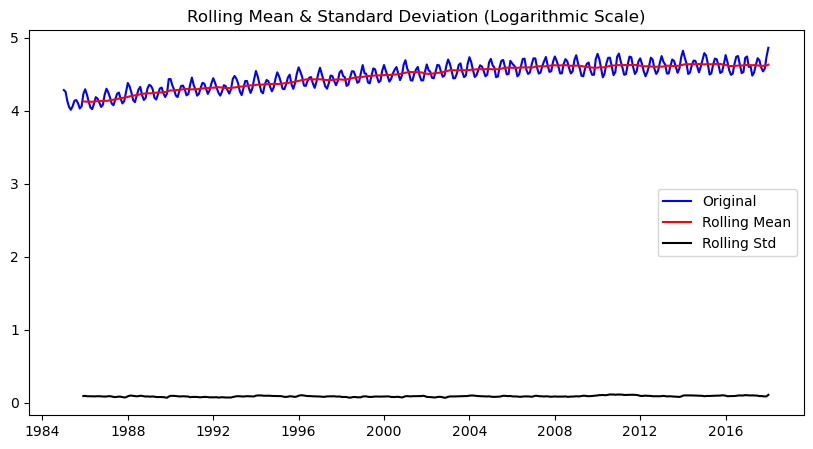

In [203]:
plt.figure(figsize=(10,5))
plt.plot(data_log, color='blue', label='Original')
plt.plot(rollmean_log, color='red', label='Rolling Mean')
plt.plot(rollstd_log, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation (Logarithmic Scale)')

From above graph we can say that, we slightly bettered our previous results. 

From the above graph,data log and mean log both have the trend component. Thus subtracting one from the other should remove the trend component.

### We are gonna subtract data log and mean log in order to remove trends 

In [204]:
data_new=data_log - rollmean_log

In [205]:
data_new.head

<bound method NDFrame.head of             consumption
date                   
1985-01-01          NaN
1985-02-01          NaN
1985-03-01          NaN
1985-04-01          NaN
1985-05-01          NaN
...                 ...
2017-09-01    -0.022477
2017-10-01    -0.076443
2017-11-01    -0.041347
2017-12-01     0.121560
2018-01-01     0.232057

[397 rows x 1 columns]>

In [206]:
# we removed the NAN values from new datasets 
data_new.dropna(inplace=True)

In [207]:
data_new.head

<bound method NDFrame.head of             consumption
date                   
1985-12-01     0.103961
1986-01-01     0.167724
1986-02-01     0.095629
1986-03-01     0.007329
1986-04-01    -0.079115
...                 ...
2017-09-01    -0.022477
2017-10-01    -0.076443
2017-11-01    -0.041347
2017-12-01     0.121560
2018-01-01     0.232057

[386 rows x 1 columns]>

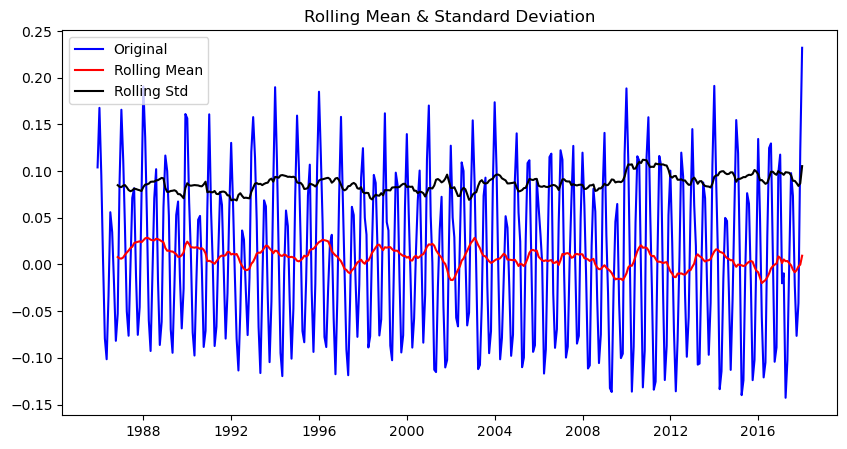

Results of Dickey Fuller Test:
Test Statistic                  -5.211586
p-value                          0.000008
#Lags Used                      15.000000
Number of Observations Used    370.000000
Critical Value (1%)             -3.448148
Critical Value (5%)             -2.869383
Critical Value (10%)            -2.570948
dtype: float64


In [208]:
test_stationarity(data_new)

we can see that our new data has become stationary and we can implement forecasting algorithms. Even ,Dickey fuller test also shows the same in numbers

## Time Shift Transformation namely differencing in order to make stationary situation more better

<bound method NDFrame.head of             consumption
date                   
1985-01-01          NaN
1985-02-01    -0.025609
1985-03-01    -0.123680
1985-04-01    -0.083082
1985-05-01    -0.038242
...                 ...
2017-09-01    -0.099489
2017-10-01    -0.052051
2017-11-01     0.038991
2017-12-01     0.164337
2018-01-01     0.120441

[397 rows x 1 columns]>

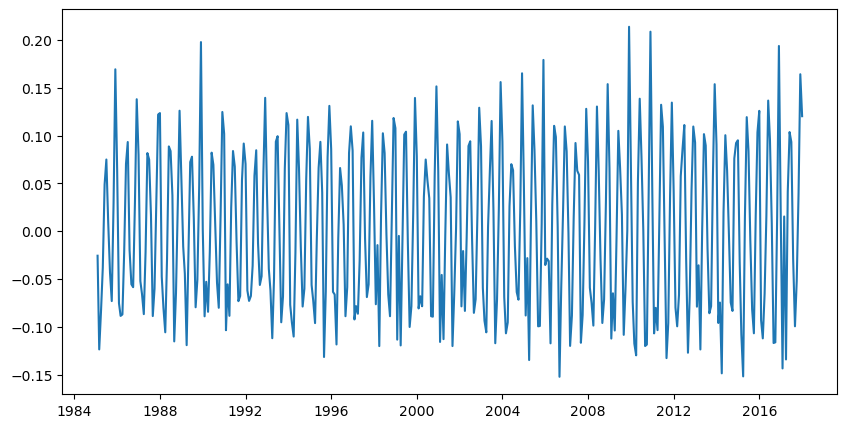

In [209]:
data_log_d= data_log - data_log.shift()
plt.figure(figsize=(10,5))
plt.plot(data_log_d)
data_log_d.head

In [210]:
# we reomve NAN values from the datasets

data_log_d.dropna(inplace=True)
data_log_d.head

<bound method NDFrame.head of             consumption
date                   
1985-02-01    -0.025609
1985-03-01    -0.123680
1985-04-01    -0.083082
1985-05-01    -0.038242
1985-06-01     0.048954
...                 ...
2017-09-01    -0.099489
2017-10-01    -0.052051
2017-11-01     0.038991
2017-12-01     0.164337
2018-01-01     0.120441

[396 rows x 1 columns]>

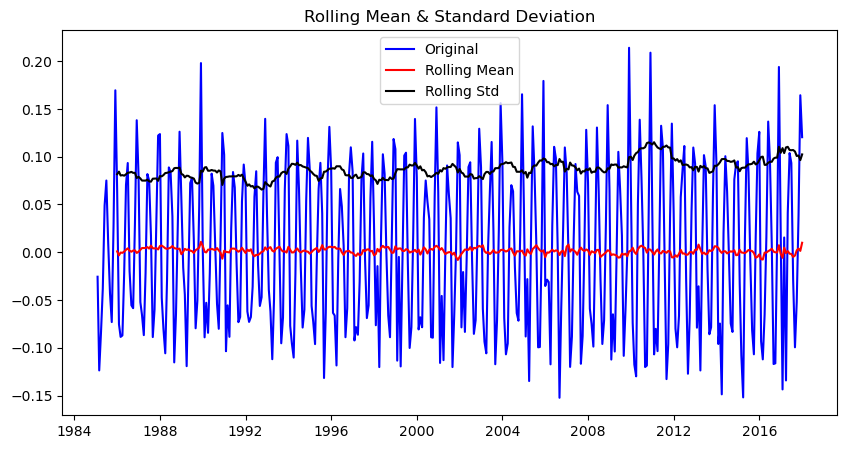

Results of Dickey Fuller Test:
Test Statistic                -6.748333e+00
p-value                        2.995161e-09
#Lags Used                     1.400000e+01
Number of Observations Used    3.810000e+02
Critical Value (1%)           -3.447631e+00
Critical Value (5%)           -2.869156e+00
Critical Value (10%)          -2.570827e+00
dtype: float64


In [211]:
test_stationarity(data_log_d)

As you can see , the performance has become better in this case especially p value and test statistics

## Now , it is time to perform data decomposition because there are many pattern in my data

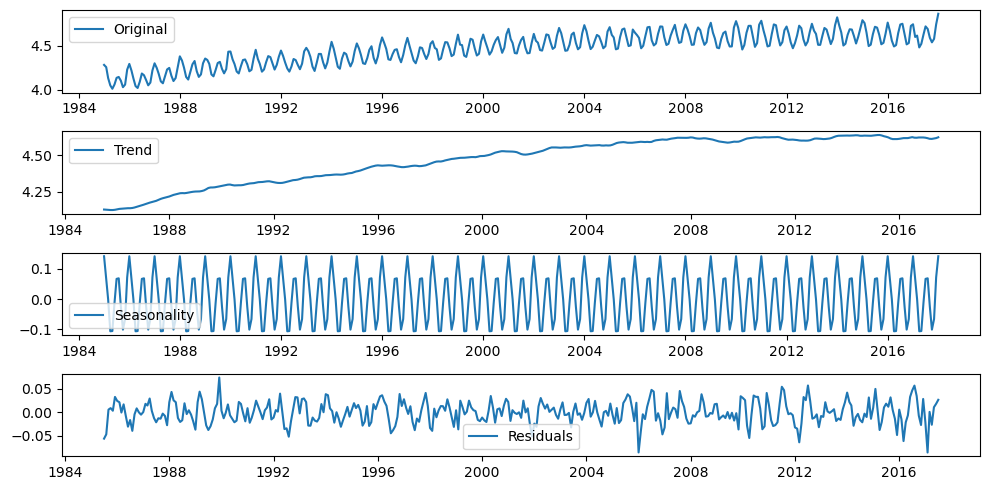

In [212]:
decomposition = seasonal_decompose(data_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,5))
plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## in some cases , ther are just seasonality and trend mostly we can say , that is why I want to remove it from data becasue it includes many NAN values , no sense to keep it here 

In [213]:
data_dec = residual
data_dec.head

<bound method NDFrame.head of date
1985-01-01   NaN
1985-02-01   NaN
1985-03-01   NaN
1985-04-01   NaN
1985-05-01   NaN
              ..
2017-09-01   NaN
2017-10-01   NaN
2017-11-01   NaN
2017-12-01   NaN
2018-01-01   NaN
Name: resid, Length: 397, dtype: float64>

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

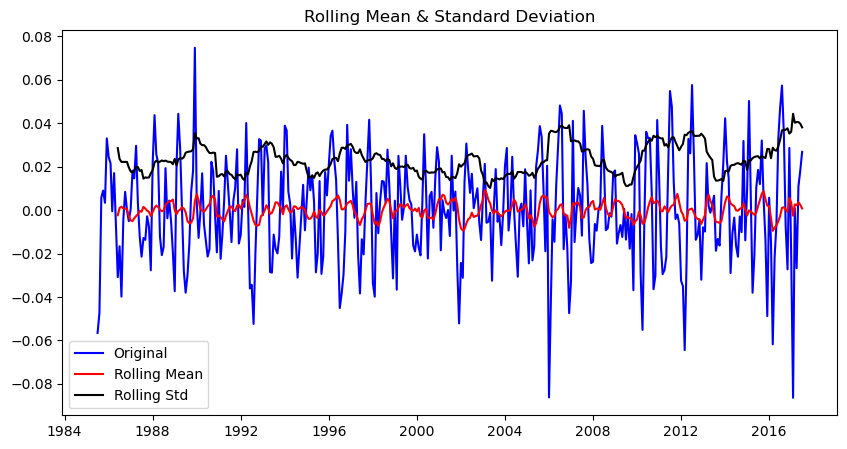

In [214]:
# remove NAN values from data
data_dec.dropna(inplace=True)
rollmean_decompose = data_dec.rolling(window=12).mean()
rollstd_decompose = data_dec.rolling(window=12).std()

plt.figure(figsize=(10,5))
plt.plot(data_dec, color='blue', label='Original')
plt.plot(rollmean_decompose, color='red', label='Rolling Mean')
plt.plot(rollstd_decompose, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

## Plotting ACF (AutoCorrelation Function) & PACF (Partial AutoCorrelation Function) in oder to find relationship between current and past data. Plotting the ACF and PACF functions helps in identifying the appropriate orders of the AR (p) and MA (q) components for the ARIMA model.

In [215]:
lag_acf = acf(data_log_d, nlags=20)
lag_pacf = pacf(data_log_d, nlags=20, method='ols')

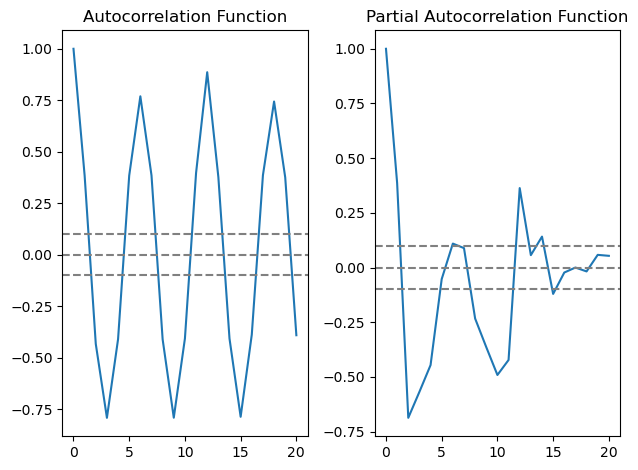

In [216]:
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_d)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_d)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_d)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_d)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

ased on the ACF graph, the curve intersects the y=0.0 line at x=2, which suggests that, according to theory, Q = 3. Similarly, the PACF graph shows the curve crossing the y=0.0 line at x=2, indicating that P = 3.

## ARIMA is AR + I + MA. Before, we see an ARIMA model, let us check the results of the individual AR & MA model. Note that, these models will give a value of RSS. Lower the RSS values indicates a better model.

In [217]:
data_log_d.head

<bound method NDFrame.head of             consumption
date                   
1985-02-01    -0.025609
1985-03-01    -0.123680
1985-04-01    -0.083082
1985-05-01    -0.038242
1985-06-01     0.048954
...                 ...
2017-09-01    -0.099489
2017-10-01    -0.052051
2017-11-01     0.038991
2017-12-01     0.164337
2018-01-01     0.120441

[396 rows x 1 columns]>

## we are gonna apply for different forecasting models in order to check the best performance inside of thenm

### Split the data into test and train part 

In [218]:
from datetime import datetime, timedelta
train = datetime(2015,1,1)
test = datetime(2018,1,1)

train_data = data_log_d[:train]
test_data = data_log_d[train+timedelta(days=1):test]


In [219]:
pred_start = test_data.index[0]
pred_end = test_data.index[-1]

In [220]:
test_data

,consumption
date,
2015-02-01,-0.032886
2015-03-01,-0.107945
2015-04-01,-0.151921
2015-05-01,0.014896
2015-06-01,0.119439
2015-07-01,0.083918
2015-08-01,-0.009386
2015-09-01,-0.081660
2015-10-01,-0.106806


## We will compare two algorithms of forecast below by showing the prediction and comparing them by metrics . we will know which one shows the better result

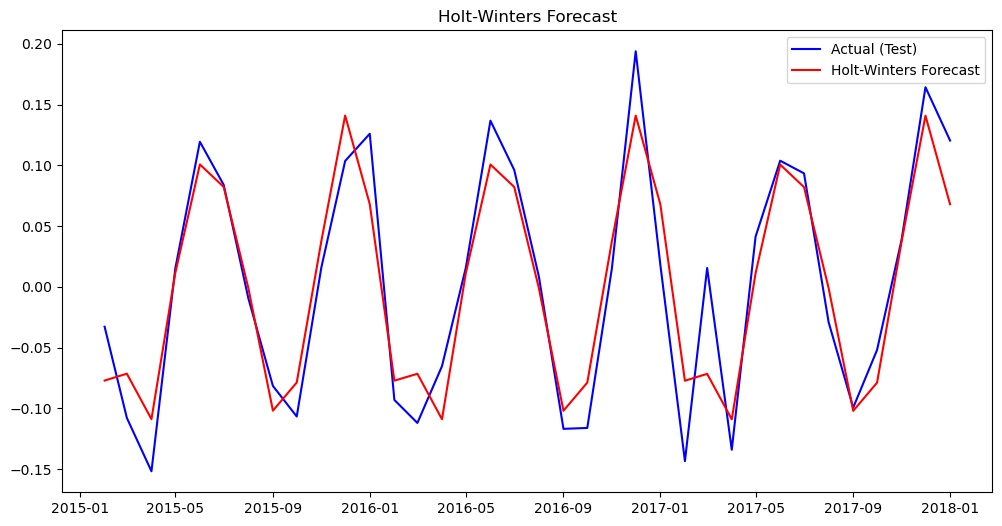

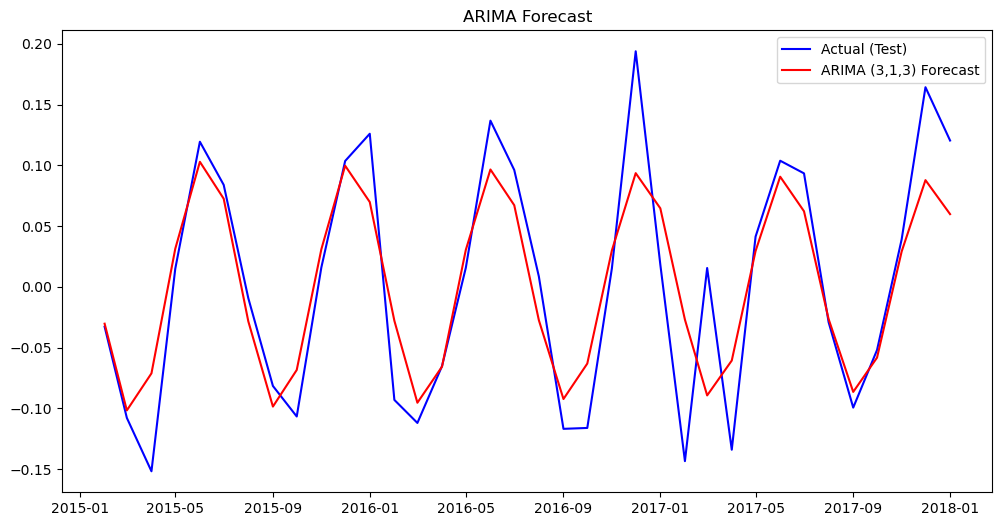

           Model       MAE       MSE      RMSE       MAPE
0   Holt-Winters  0.028362  0.001202  0.034676  64.424903
1  ARIMA (3,1,3)  0.034563  0.002172  0.046603  77.340065


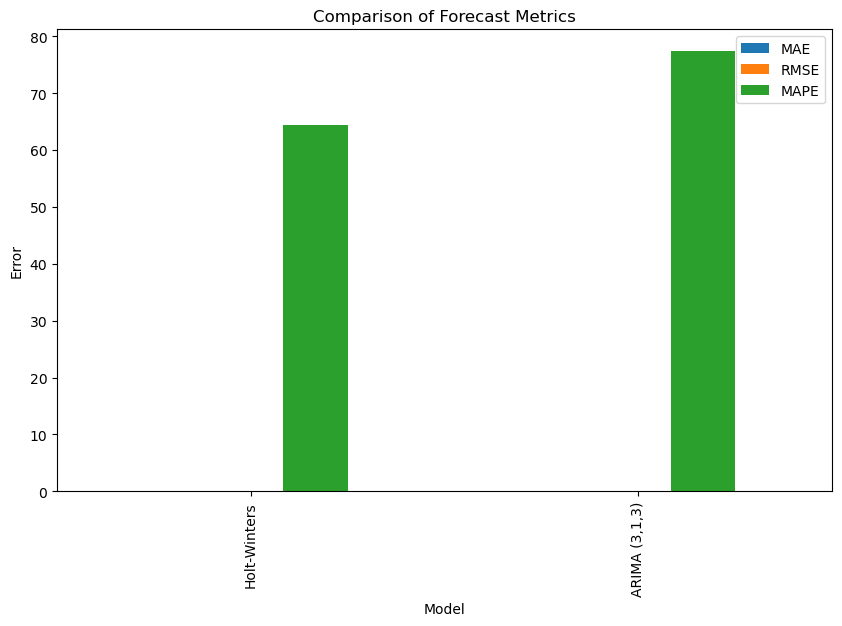

In [232]:

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sms


def calculate_metrics(actual, predicted, model_name):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return {"Model": model_name, "MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape}

# store results
metrics_df = pd.DataFrame()

### ExponentialSmoothing

hw_model = ExponentialSmoothing(train_data['consumption'], trend='add', seasonal='add', seasonal_periods=12).fit()
# Forecast
hw_forecast = hw_model.forecast(steps=len(test_data))
# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_data['consumption'], label='Actual (Test)', color='blue')
plt.plot(test_data.index, hw_forecast, label='Holt-Winters Forecast', color='red')
plt.title('Holt-Winters Forecast')
plt.legend()
plt.show()
# Calculate metrics
hw_metrics = calculate_metrics(test_data['consumption'], hw_forecast, "Holt-Winters")
metrics_df = metrics_df.append(hw_metrics, ignore_index=True)



###### Armia 
arima_model = sms.tsa.arima.ARIMA(train_data['consumption'], order=(3, 1, 3)).fit()
# Forecast
arima_forecast = arima_model.forecast(steps=len(test_data))
# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_data['consumption'], label='Actual (Test)', color='blue')
plt.plot(test_data.index, arima_forecast, label='ARIMA (3,1,3) Forecast', color='red')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()
# Calculate metrics
arima_metrics = calculate_metrics(test_data['consumption'], arima_forecast, "ARIMA (3,1,3)")
metrics_df = metrics_df.append(arima_metrics, ignore_index=True)


print(metrics_df)


metrics_df.set_index("Model")[["MAE", "RMSE", "MAPE"]].plot(kind="bar", figsize=(10, 6))
plt.title("Comparison of Forecast Metrics")
plt.ylabel("Error")
plt.show()


# Report

## Dataset

The data set used here has only 2 columns, once column is date and the other column relates to the consumption percentage.

## Analysis 

I firstly learn the dataset and then I should define the dataset is stationary or not . After checking some Augmented Dickey-Fuller  and Mean and STD, it was clear that dataset is not stationary so that I converted the dataset into stationary by log transformation, difference transformation and substract the mean value from actual value to make it more stationary. then, I tested again with ADF and this time , the result was exceptable. Then , I built two models for forecasting in order to compare the performance of models.

## Conclusion 

I built two models namely HOT winters and Arima. As shown above, the metrics show that Armia is more superior compared to hotwinter when it come to this dataset